In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy as sp
from tqdm import tqdm
from scipy.integrate import simps, trapz
import matplotlib.pyplot as plt
import imageio
import multiprocessing
from helpers import (Fy, find_closest_element,  compute_coverage, #predict_single_density,
confidence_interval, confidence_interval, generate_fixed_terms, get_ci)
from density_predictor_class_val import density_predictor

In [2]:
# read in val data
B_zeta = np.load('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/B_zeta_val.npy')
beta = np.genfromtxt('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/beta/beta.csv', delimiter = ',')
#B_zeta = B_zeta.reshape(B_zeta.shape[0], B_zeta.shape[])
true_y = np.load('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/labels_val.npy')
true_z = np.load('../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/Bzeta/tr_labels_val.npy')

B_zeta = B_zeta[np.abs(true_y) < 50,:] 
true_z = true_z[np.abs(true_y) < 50]
true_y = true_y[np.abs(true_y) < 50]

density_path = '../../../../data/commaai/density/gaussian_density.csv'
density = pd.read_csv(density_path)

no_points = 500

In [3]:
dens = density_predictor(B_zeta, true_y, density, no_points)

In [4]:
result_va_ridge = dens.get_density('va_ridge')
result_hmc_ridge = dens.get_density('hmc_ridge')
result_va_horse = dens.get_density('va_horseshoe')
result_hmc_horse = dens.get_density('hmc_horseshoe')

  0%|          | 80/94805 [00:00<01:59, 793.10it/s]

computing densities for each observation


  2%|▏         | 1888/94805 [00:00<00:04, 18879.30it/s]

computing mean prediction for each observation


  2%|▏         | 1587/94805 [00:00<00:05, 15869.49it/s]

computing variance prediction for each observation


100%|██████████| 94805/94805 [00:06<00:00, 15493.69it/s]


In [5]:
df = pd.DataFrame({'va_ridge' : result_va_ridge['variance prediction'],
                 'hmc_ridge' : result_hmc_ridge['variance prediction'],
                 'va_horse' : result_va_horse['variance prediction'],
                 'hmc_horse' : result_hmc_horse['variance prediction']})

In [6]:
df.to_csv('../../../../data/commaai/predictions/cil/variance.csv')

In [7]:
z_pred = B_zeta.dot(beta) 
y_pred = np.array([density.loc[find_closest_element(norm.cdf(i), density['cdf']), 'axes'] for i in tqdm(z_pred)])

100%|██████████| 94805/94805 [00:32<00:00, 2883.38it/s]


In [8]:
grid = np.linspace(0,180,1000)
def error_vs_variance(result, grid):
    mse_list = []
    for i in grid:
        index = np.array(result['variance prediction'] < i)
        if np.sum(index) > 0:
            mse = np.mean(np.abs(true_y[index] -  np.array(result['mean prediction'])[index])**2)
        else:
            mse = float('NaN')
        mse_list.append(mse)
    return(np.array(mse_list))

In [9]:
er_conf_va_ridge = error_vs_variance(result_va_ridge, grid)
er_conf_hmc_ridge = error_vs_variance(result_hmc_ridge, grid)
er_conf_va_horse = error_vs_variance(result_va_horse, grid)
er_conf_hmc_horse = error_vs_variance(result_hmc_horse, grid)

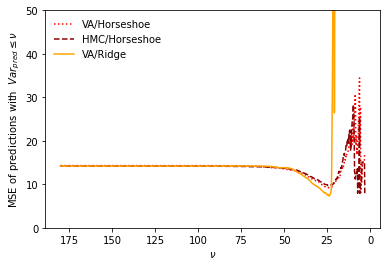

In [10]:
#plt.plot(grid, er_conf_hmc_ridge, label = 'HMC/Ridge', color = 'darkorange')
plt.plot(grid, er_conf_va_horse, label = 'VA/Horseshoe', color = 'red', linestyle = 'dotted')
plt.plot(grid, er_conf_hmc_horse, label = 'HMC/Horseshoe', color = 'darkred', linestyle = 'dashed')
plt.plot(grid, er_conf_va_ridge, label = 'VA/Ridge', color = 'orange')
plt.legend()
plt.legend(framealpha=0.0)
plt.ylim(0,50)
plt.gca().invert_xaxis()
plt.xlabel(r'$\nu$')
plt.ylabel(r'MSE of predictions with  $Var_{pred} \leq \nu$')
plt.savefig('error_vs_confidence_cil.png')

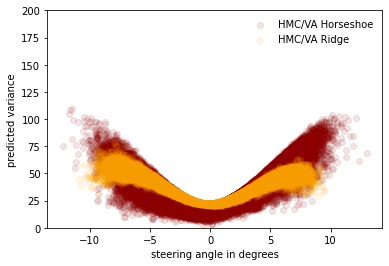

In [16]:
plt.scatter(result_hmc_horse['mean prediction'], result_hmc_horse['variance prediction'], alpha = 0.1, color = 'darkred', label = 'HMC/VA Horseshoe')
plt.scatter(result_hmc_ridge['mean prediction'], result_hmc_ridge['variance prediction'], alpha = 0.1, color = 'orange', label = 'HMC/VA Ridge')
plt.legend()
plt.legend(framealpha=0.0)
#for lh in leg.legendHandles: 
#    lh._legmarker.set_alpha(1)
#    lh._legmarker.set_framealpha(0.0)
plt.legend(framealpha=0.0)
plt.ylim(0,200)
plt.xlabel('steering angle in degrees')
plt.ylabel('predicted variance')
plt.savefig('mean_vs_var_cil.png')